# Что такое a/b тесты
Предположим, в некоторой системе у нас есть целевой показатель и мы хотим его улучшить поменяв один из компонентов системы. Например увеличить число покупок в интернет магазине, добавив "покупку в один клик". Или увеличить число подписчиков ютюб канала за счёт дополнительной просьбы подписывать в конце видео.

![Image of ab tests](https://50wheel.com/wp-content/uploads/2016/11/video-marketing-split-testing-1620x800.png)

Самый простой вариант: внести изменение и посмотреть как поменяется целевой показатель. Однако на целевой показатель действует множество факторов непостоянных во времени, которые мы зачастую не можем контролировать. Например, сезонность. Если на выходных продажи выше, запустив эксперимент перед выходными нам будет совсем не просто отличить влияние наших изменений от обычного субботнего подъёма показателей. Уровень nightmate: в программатик рекламе 3 периода сезонности (неделя, месяц, квартал)

![pasted_Image0.png](https://i.postimg.cc/x1kvyJDx/pasted_Image0.png)

Вариант по-лучше: запустить две версии системы (с изменением и без) одновременно. Тогда все факторы будут действовать на обе версии одинаково. Например создать две версии веб-сайта и раскидывать пользователей между ними случайным образом. Или поделить пациентов на две группы и дать им лекарство и плацебо

Однако в большинстве процессов целевой показатель зависит от массы случайностей. 

## Даже если пользователей случайным образом разбить на две группы и больше ничего не делать, результаты этих двух груп будут хоть чуть-чуть отличаться. 

Даже если подкидывать 2 одинаковые монетки, число выпавших орлов и решек, скорее всего будет разным (вы можете попробовать это самостоятельно!). Как же отличить случайность от закономерности, сигнал от шума?

# Проверка статистических гипотез

По сути дела, данные полученные в рамках a/b теста это две случайные выборки. При этом о реальных свойствах системы до и после изменения мы не знаем, мы можем лишь делать вывод о них на основе сравнения выборок.

Есть другие применения проверке статистических гипотез, но применительно к ситуации с a/b тестом мы пытаемся оценить вероятность того, что полученные выборки относятся к системам с одинаковым или не улучшенным целевым показателем. Это называется нулевая гипотеза. Если мы полагаем, что вероятность того, что нулевая гипотеза верна, с учётом собранных в рамках эксперимента данных, меньше некоторого значения, мы выбираем в качестве победившей нашу альтернативную гипотезу.

Есть координально иные подходы к оценке a/b, я рассмотрю самый, на мой взгляд распространённый и простой вариант.

# Один из самых распространённых подходов

In [2]:
import numpy as np
import pandas as pd
from plotnine import *
from plotnine import options
import itertools

In [3]:
import warnings
warnings.filterwarnings('ignore')
options.figure_size = (10, 4.8)

Пользователь заходит на лэндинг и с вероятность 20% подписывается на сервис. Число пользователей из N зашедших которое подпишется на серверис можно моделировать при помощи биномиального распределения.

## Биномиальное распределение: есть некоторые случайное событие у котого есть 2 возможных исхода. Купил / не купил, орёл/решка. Сколько раз из N событие окончиться  определённым образом, если каждый раз вероятность такого исхода равна некоторй величине p.

In [ ]:
Ниже полученное практическим путём распределение вероятностей для N = 1.

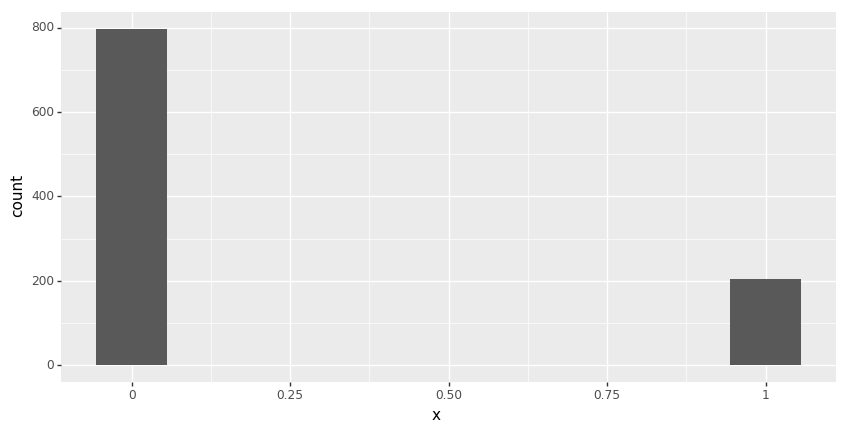

<ggplot: (-9223363275669744724)>

In [4]:
qplot(np.random.binomial(1, 0.2, 1000), bins=10, xlab='x') 

`np.random.binomial` - функция из библиотеки numpy которая позволяет получить случайную выборку из биномиального распределения

In [190]:
def merge_lists(x):
    return list(itertools.chain.from_iterable(x))

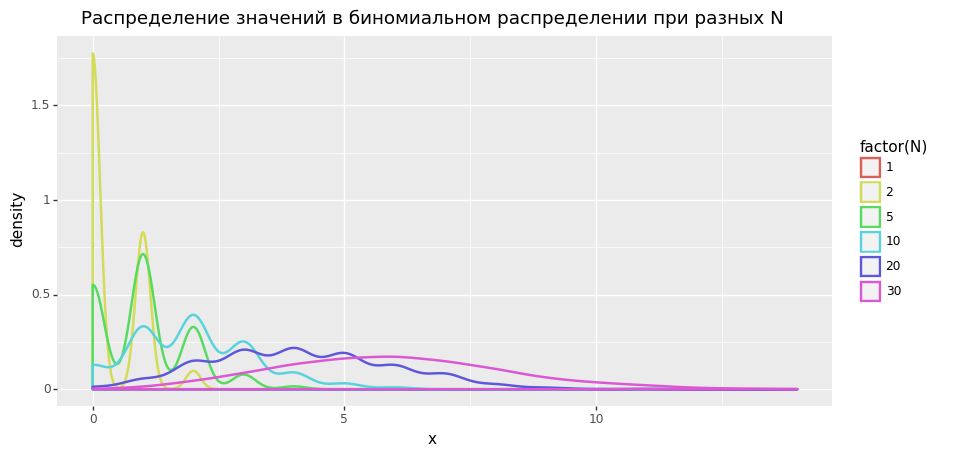

<ggplot: (8761182791439)>

In [193]:
df = pd.DataFrame({
    'x': merge_lists([np.random.binomial(N, 0.2, 1000) for N in [1, 2, 5, 10, 20, 30]]),
    'N': merge_lists([np.repeat(N, 1000) for N in [1, 2, 5, 10, 20, 30]])
})

ggplot(df, aes(x='x', color='factor(N)')) + geom_density(size=1) + ggtitle("Распределение значений в биномиальном распределении при разных N")

Чем больше N, тем больше распределение напоминает ровный симметричный холм. Посмотрим на что похоже такое распределение поближе.

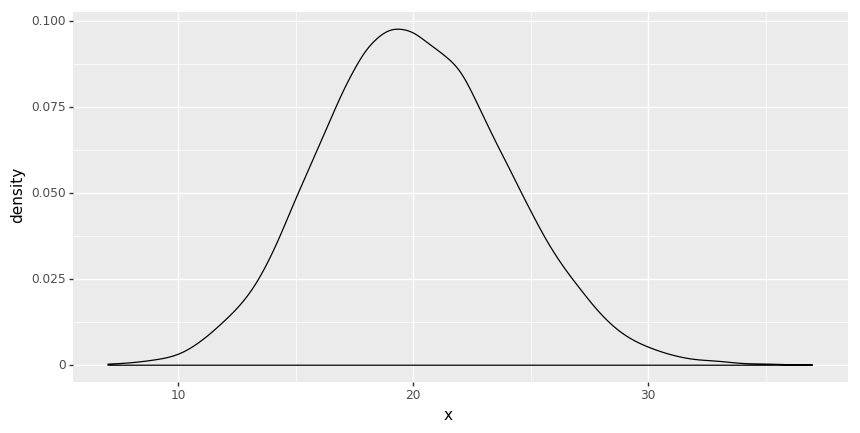

<ggplot: (-9223363275669767904)>

In [7]:
qplot(np.random.binomial(100, 0.2, 10000), geom='density', xlab='x') 

## Да это же старая добрая гаусиана! Под маской биномиального скрывалось нормальное распределение!

![img](https://i.imgflip.com/1ntwo2.jpg)

Попробуем что-нибудь совершенно другое. Как на счёт сервиса, которые предлагает два плана с разной стоимостью: простой план за доллар и крутой план всё включено за 20 долларов. 90% процентов пользователей не берёт ничего, 8% подписываются на дешёвый, 2% берут самый дорогой.

In [8]:
def run_arpu_trial(N):
    prices = [0, 1, 20]
    chances = [0.9, 0.08, 0.02]
    
    return np.random.choice(prices, N, p=chances)

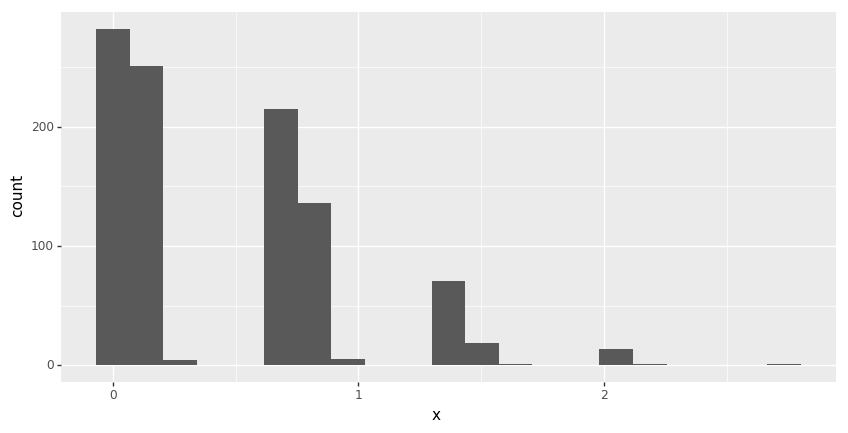

<ggplot: (-9223363275671986621)>

In [9]:
qplot([np.mean(run_arpu_trial(30)) for i in range(1000)], xlab='x')

По-моему это вообще ни на что непохоже! А что если брать выборку сильно больше 30 пользователей?

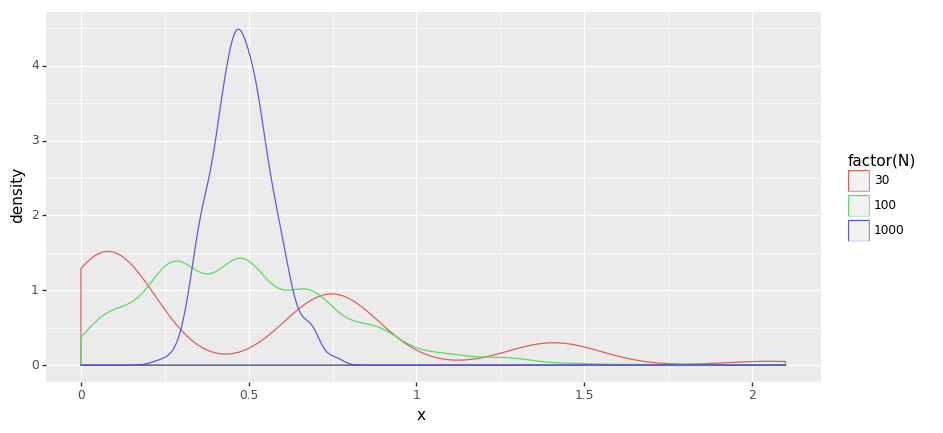

<ggplot: (-9223363275672003868)>

In [10]:
df = pd.DataFrame({
    'x': join([[np.mean(run_arpu_trial(N)) for i in range(1000)] for N in [30, 100, 1000]]),
    'N': join([np.repeat(N, 1000) for N in [30, 100, 1000]])
})

ggplot(df, aes(x='x', color='factor(N)')) + geom_density()

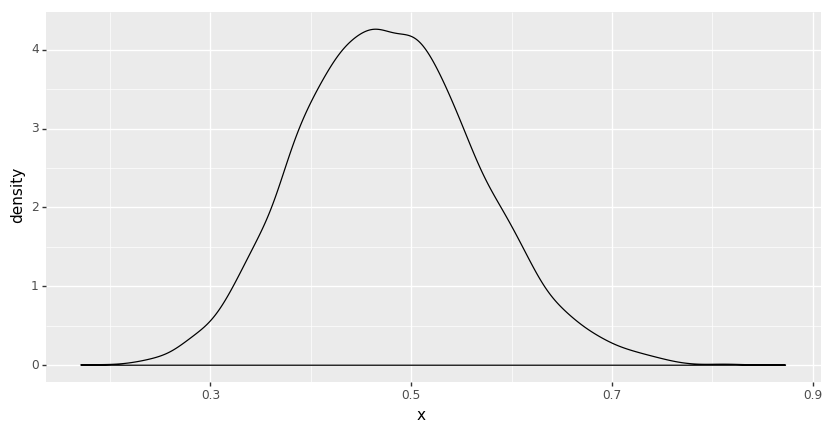

<ggplot: (-9223363275669767827)>

In [11]:
qplot([np.mean(run_arpu_trial(1000)) for i in range(10000)], geom='density', xlab='x') 

# Да что же это такое?! Снова гаусиана!

Ну да, это просто центральная предельная теорема. Рекоммендую загуглить доску Гальтона

Меж тем нормальное распределение будет и у разницы ARPU двух групп.

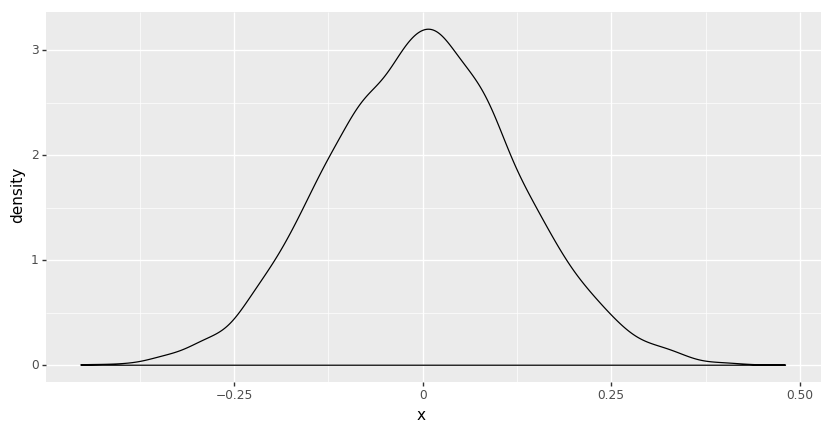

<ggplot: (-9223363275671962743)>

In [12]:
qplot(
    [np.mean(run_arpu_trial(1000)) - np.mean(run_arpu_trial(1000)) for i in range(10000)],
    geom='density',
    xlab='x'
)

Круче всего для получения всех этих результатов не потребовалось ни одной формулы. Только генератор случайных чисел и немного процессорного времени

# А что со стандартным отклонением внутри сэмпла?

In [13]:
np.mean([np.std(run_arpu_trial(1000)) for i in range(10000)])

2.7786765382820575

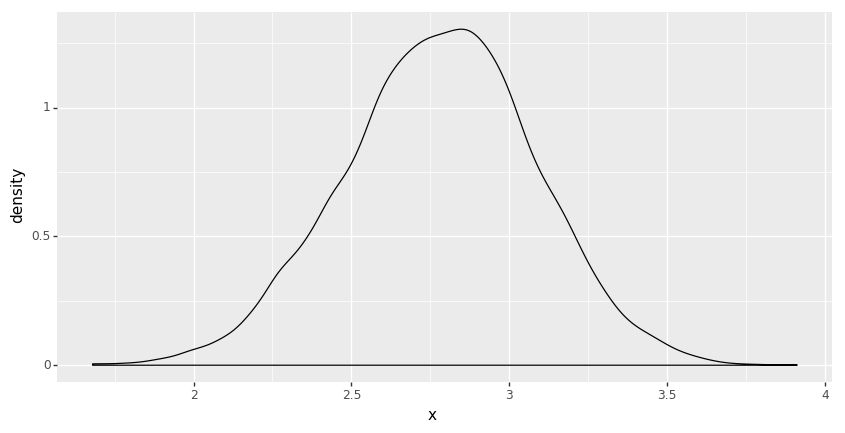

<ggplot: (8761182783068)>

In [14]:
qplot([np.std(run_arpu_trial(1000)) for i in range(10000)], geom='density', xlab='x') 

### И вновь распределение похожее на нормальное
Также довольно широкий разброс значений, ниже - доверительный интервал

In [15]:
np.percentile([np.std(run_arpu_trial(1000)) for i in range(10000)], 2.5)

2.1856895936980627

In [16]:
np.percentile([np.std(run_arpu_trial(1000)) for i in range(10000)], 97.5)

3.3533146288411415

А вот - доверительный интервал для среднего по выборке

In [17]:
np.percentile([np.mean(run_arpu_trial(1000)) - np.mean(run_arpu_trial(1000)) for i in range(10000)], 2.5)

-0.247

In [18]:
np.percentile([np.mean(run_arpu_trial(1000)) - np.mean(run_arpu_trial(1000)) for i in range(10000)], 97.5)

0.24

И первая формула за весь ноутбук. Тот же доверительный интервал рассчитанный по центральной предельной теореме.

1) Стандартное отклонение среднего по выборке = Стандартное отклонение в исходной популяции делённое на корень из размера выборки

2) Стандартное отклонение для разницы двух распределений = стандартное отклонение одного распределения на корень из двух

3) 95% значений лежат не далее 1.96 стандартных отклонений от мат ожидания

In [19]:
(2.788 / np.sqrt(1000)) *  np.sqrt(2) * 1.96

0.244378974833761

### Close enough!

# А теперь к проверке статистических гипотез

1) Есть две выборки. В них известно среднее и стандартное отклонение

2) Нужно определить какой доверительный интервал для распределения разницы средних был бы если бы нулевая гипотеза была верна

3) При нулевой гипотезе мат ожидание для распределения разницы средних = 0. Осталось найти стандартное отклонение генеральной совокупностей и посчитать из него стандартное отклонение разницы средних

4) Но мы ничего не знаем про генеральные совокупности, у нас только выборки :-( Остаётся брать стандартное отклонение в выборке

5) Это вообще нормально? Оно же всё время разное?!

6) Есть лишь один способ проверить!

In [20]:
def run_ab_test_arpu_simulation():
    A = run_arpu_trial(1000)
    B = run_arpu_trial(1000)
    
    z = (np.mean(A) - np.mean(B)) / np.sqrt(np.std(A)**2 / len(A) + np.std(B)**2 / len(B))
    return z > 1.96 or z < -1.96

In [21]:
np.mean([run_ab_test_arpu_simulation() for i in range(50000)])

0.0508

Итак сэмулировав проведение теста при истинности нулевой гипотезы, мы получили что тест ошибается в 5% случаев. Учитывая что мы брали 95% доверительный интервал, выходит что всё работает как надо!

Далее:

2) Статистическая мощность

3) Data peeking

4) Защита от data peeking

# Ошибки второго рода

Кроме риска принять неверную гипотезу есть ещё риск не принять верную. Как его оценить?

Вернёмся к биномиальному распределению, с ним чуть проще работать. Ещё раз смоделируем работу теста при нулевой гипотезе. В обоих вариациях конверсия 10%, как будет распределена разница конверсии между вариациями при размере выборок в 1000?

In [98]:
dist = [np.random.binomial(1000, p=0.1) / 1000 - np.random.binomial(1000, p=0.1) / 1000 for i in range(50000)]

In [99]:
np.mean(dist)

2.1419999999999985e-05

In [100]:
np.std(dist)

0.013436633550990368

При нулевой гипотезе конверсия одинаковая, для распределения бернули стандартное отклонение можно рассчитать их конверсии, значит и стандартное отклонение в обоих вариация одинаковое

`std = sqrt(p * (1 - p))`

для разницы между двумя случайными величинами

`diff_std = sqrt(2 * p * (1 - p))`

для среднего по выборке из N элементов

`sqrt(2 * p * (1 - p)) / sqrt(N)`

In [114]:
np.sqrt(2 * 0.1 * (1 - 0.1)) / np.sqrt(1000)

0.01341640786499874

Всё сходится! Как насчёт доверительного интервала?

In [115]:
np.percentile(dist, 95) / np.std(dist)

1.6373148762681304

In [116]:
import scipy.stats as st
st.norm.ppf(0.95)

1.6448536269514722

95% значений находятся не далее чем 1.645 стандартных отклонений от 0

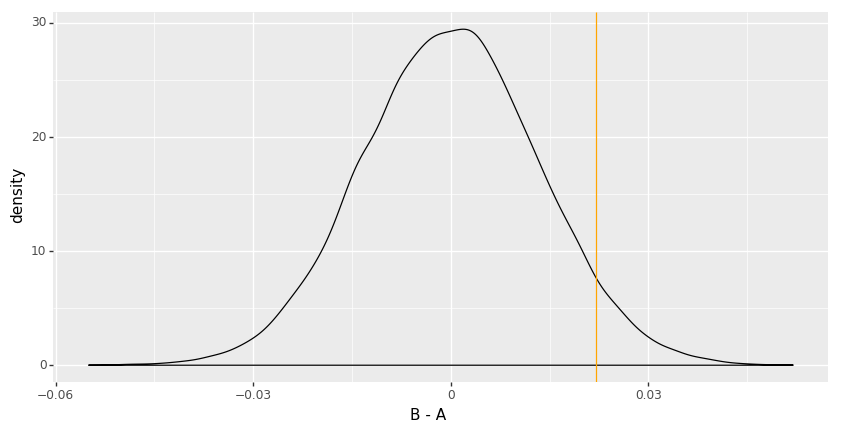

<ggplot: (8761182175601)>

In [104]:
qplot(dist, geom='density', xlab='B - A') + geom_vline(xintercept=np.std(dist) * 1.645, color='orange')

Теперь выберем альтернативную гипотезу. Пусть в вариации B конверсия вырастет до 13%

In [105]:
dist_alt = [np.random.binomial(1000, p=0.13) / 1000 - np.random.binomial(1000, p=0.10) / 1000 for i in range(50000)]

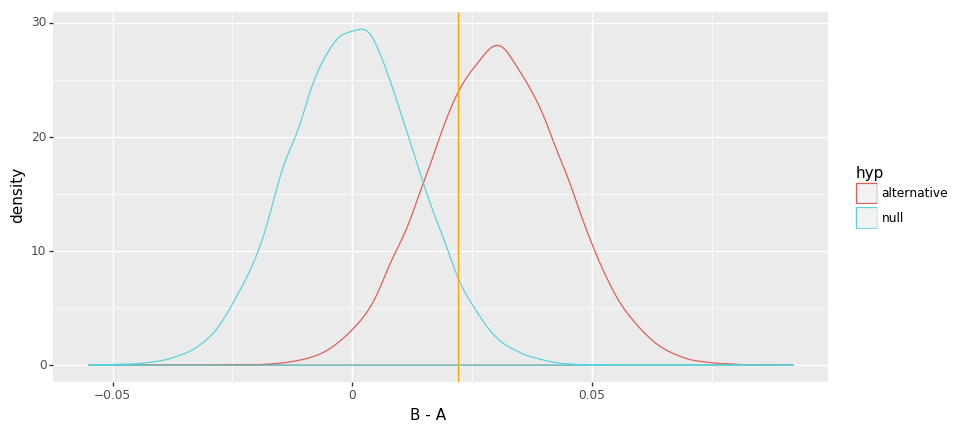

<ggplot: (8761182129349)>

In [106]:
df = pd.DataFrame({'B - A': dist + dist_alt, 'hyp': ['null'] * 50000 + ['alternative'] * 50000})

ggplot(df, aes(x='B - A', color='hyp')) + geom_density() + geom_vline(xintercept=np.percentile(dist, 95), color='orange')

Часть значений при альтернативной гипотезе лежат в границах 95% интервала для нулевой гипотезы

Это значит что для этих значений мы не сможет отвергнуть нулевую гипотезу

In [107]:
np.mean(np.array(dist_alt) <= np.percentile(dist, 95))

0.29974

Это 30% от всех значений

Оставшиеся 70% это статистическая мощность

Примерно такой же результат можно получить через калькулятор стат мощности из библиотеки statsmodels

In [118]:
import statsmodels.stats.power as smp
from statsmodels.stats.proportion import proportion_effectsize

smp.NormalIndPower().solve_power(proportion_effectsize(0.13, 0.10), nobs1=1000, alpha=0.05, alternative='larger')

0.6779874097293103

Теперь можно сделать простую симуляцию a/b тестаи посмотреть как часто выбранный подход ошибается при нулевой и альтернативной гипотезе

In [124]:
std_null = np.sqrt(2 * 0.1 * (1 - 0.1)) / np.sqrt(1000)

def run_ab_test_conv_simulation(hyp):
    A = np.random.binomial(1000, p=0.10) / 1000
    B = np.random.binomial(1000, p=0.13 if hyp == 'alternative' else 0.10) / 1000
    
    z = (B - A) / std_null
    return z >  1.645

In [126]:
np.mean([run_ab_test_conv_simulation('null') for i in range(10000)])

0.05

In [127]:
np.mean([run_ab_test_conv_simulation('alternative') for i in range(10000)])

0.7086

# Подглядывание

Вооружившись стат симуляцией можно исследовать также такое явление как подглядывание или data peeeking

Стандартный подход к a/b подразумевает подсчёт стат значимости 1 раз по достижению заранее обозначенного размера выборки. именно так построены симуляции выше. А что будет если нарушить это условие?

Скажем нетерпеливый аналитик будет проверять результаты a/b каждые 100 пользователей и остановит тест как только будет достигнута стат значимость

In [135]:
from statsmodels.stats.proportion import proportions_ztest

def run_ab_test_conv_peeking_simulation(steps):
    # число пользоватлей сконверченных в каждой из вариаций
    varA = 0
    varB = 0 
    
    # в рамках теста имеется 8 участков где проверяется стат значимость
    for step in range(steps):        
        varA = varA + np.random.binomial((step + 1) * 100, p=0.10)
        varB = varB + np.random.binomial((step + 1) * 100, p=0.10)        
                
        p = proportions_ztest([varB, varA], [(step + 1) * 100, (step + 1) * 100], alternative='smaller')[1]
        if p < 0.05:
            return True
    
    return False

In [138]:
np.mean([run_ab_test_conv_peeking_simulation(1) for i in range(10000)])

0.0546

In [140]:
np.mean([run_ab_test_conv_peeking_simulation(10) for i in range(10000)])

0.2985

Вероятность ошибки первого рода выросла до 30% !

# Sequential testing

На практивке почти все кто применяют a/b тесты занимаются подглядыванием. На это есть ряд объективных причин:

1) Тест идёт очень плохо. Например вариация B сильно проигрывает вариации A, проведение теста ведёт к потере денег, а то и человеческого здоровья. Продолжать тест - страшно

2) Тест идёт очень хорошо. Вариация B выигрывает с большим отрывом, победитель заранее очевиден

3) Тест идёт так себе, результатов нет и видимо не будет. Жалко времени

Однако если использовать стандартное правило для оценки гипотез, это увличивает вероятность ошибки первого рода. К счастью есть выход! Рассмотрим пример:

In [146]:
baseline_conversion = 0.0196 # конверсия в вариации A
uplift = 0.1556 # какой рост мы ожидаем

# на каком количестве пользователей будут проводиться прроверки. рассчитано AGILE калькулятором
check_points = [3722, 7444, 11165, 14887, 18806, 22330, 26051, 29773]

# верхняя граница при пересечении которой остнавливаем тест
futility = [-1.8195, -1.0080, -.4255, 0.0606, 0.4906, 0.8841, 1.2568, 1.6664]

# нижняя граница при пересечении которой остнавливаем тест
efficacy = [ 3.7250,  3.1895,  2.8471, 2.5756, 2.3418, 2.1299, 1.9254, 1.6664]

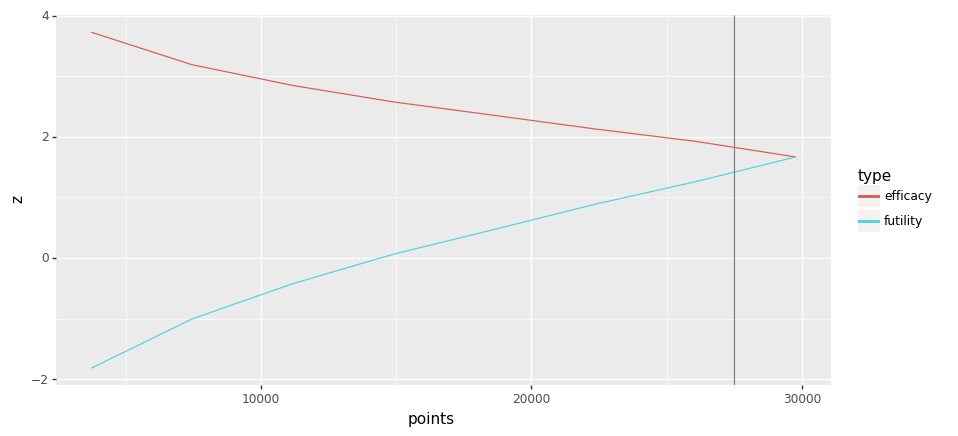

<ggplot: (-9223363275671978068)>

In [181]:
df = pd.DataFrame({
    'points': check_points * 2,
    'z': futility + efficacy,
    'type': ['futility'] * len(futility) + ['efficacy'] * len(efficacy)
})

ggplot(df, aes(x='points', y='z', color='type')) + geom_line() + geom_vline(xintercept=27488, color='grey')

## Как это работает в разных сценариях

In [155]:
def run_ab_test_conv_sequential_simulation_get_zs(uplift):
    varA = 0
    varB = 0

    # number of observations или число пользователей, принявших участие в тесте в каждой из вариаций
    nobs = 0    
    
    zs = []

    # в рамках теста имеется 8 участков где проверяется стат значимость
    for step in range(8):

        # биномиальное распределение поможект сэмулировать поведение пользователей. считаем сколько дополнительно сконвертилось с момента предыдущей проверки
        varA = varA + np.random.binomial(check_points[step] - nobs, baseline_conversion)                
        varB = varB + np.random.binomial(check_points[step] - nobs, baseline_conversion * (1 + uplift))

        nobs = check_points[step]

        z = proportions_ztest([varB, varA], [nobs, nobs], alternative='smaller')[0]
        zs.append(z)
        
    return zs

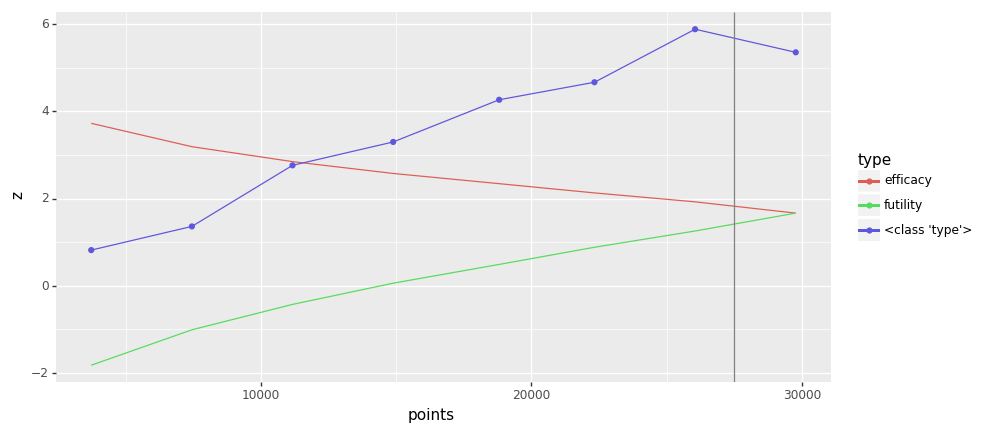

<ggplot: (-9223363275672408376)>

In [184]:
df2 = pd.DataFrame({
    'points': check_points,
    'z': run_ab_test_conv_sequential_simulation_get_zs(0.30)
})

(
    ggplot(df, aes(x='points', y='z', color='type')) 
    + geom_line() 
    + geom_point(data=df2, mapping=aes(x='points', y='z'))
    + geom_line(data=df2, mapping=aes(x='points', y='z'))
    + geom_vline(xintercept=27488, color='grey')
)

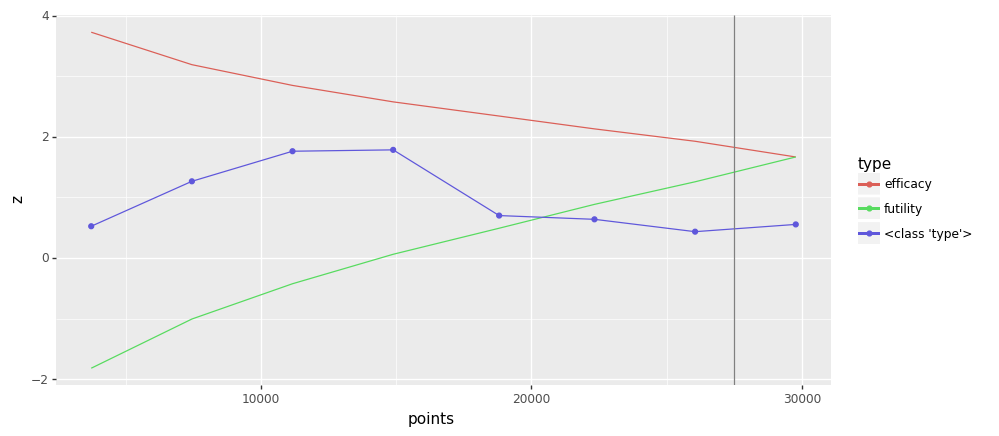

<ggplot: (8761182252685)>

In [185]:
df2 = pd.DataFrame({
    'points': check_points,
    'z': run_ab_test_conv_sequential_simulation_get_zs(0)
})

(
    ggplot(df, aes(x='points', y='z', color='type')) 
    + geom_line() 
    + geom_point(data=df2, mapping=aes(x='points', y='z'))
    + geom_line(data=df2, mapping=aes(x='points', y='z'))
    + geom_vline(xintercept=27488, color='grey')
)

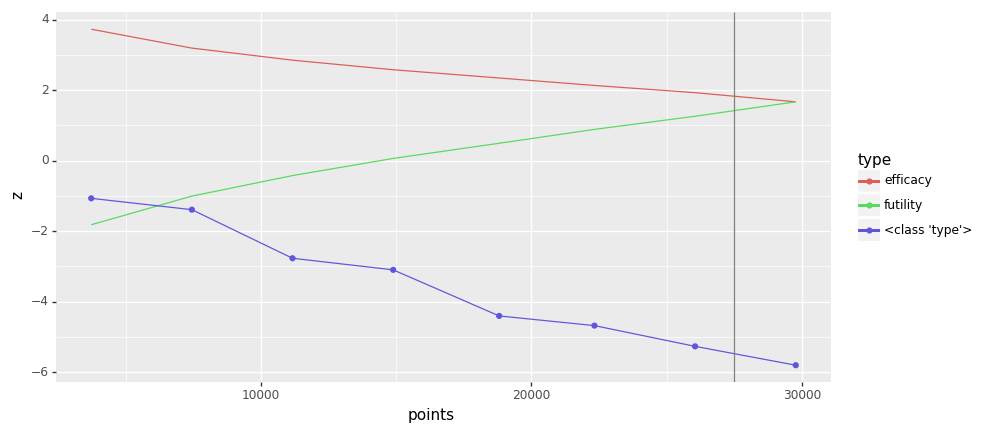

<ggplot: (-9223363275672253829)>

In [187]:
df2 = pd.DataFrame({
    'points': check_points,
    'z': run_ab_test_conv_sequential_simulation_get_zs(-0.30)
})

(
    ggplot(df, aes(x='points', y='z', color='type')) 
    + geom_line() 
    + geom_point(data=df2, mapping=aes(x='points', y='z'))
    + geom_line(data=df2, mapping=aes(x='points', y='z'))
    + geom_vline(xintercept=27488, color='grey')
)

# И проверка точности через симуляцию

In [173]:
def run_ab_test_conv_sequential_simulation(uplift):
    # число пользоватлей сконверченных в каждой из вариаций
    varA = 0
    varB = 0
    
    # number of observations или число пользователей, принявших участие в тесте в каждой из вариаций
    nobs = 0    
    
    # в рамках теста имеется 8 участков где проверяется стат значимость
    for step in range(8):
        
        # биномиальное распределение поможект сэмулировать поведение пользователей. считаем сколько дополнительно сконвертилось с момента предыдущей проверки
        varA = varA + np.random.binomial(check_points[step] - nobs, baseline_conversion)                
        varB = varB + np.random.binomial(check_points[step] - nobs, baseline_conversion * (1 + uplift))
        
        nobs = check_points[step]
                
        z = proportions_ztest([varB, varA], [nobs, nobs], alternative='smaller')[0]
        if z < futility[step]:
            return [nobs, False]
        
        if z > efficacy[step]:
            return [nobs, True]
    
    raise Exception('wtf')

In [174]:
nobs, outcomes = map(list,zip(*[run_ab_test_conv_sequential_simulation(0) for i in range(10000)]))

In [175]:
np.mean(outcomes)

0.0484

In [176]:
np.mean(nobs) / 27488.

0.5852537216239814

In [177]:
nobs, outcomes = map(list,zip(*[run_ab_test_conv_sequential_simulation(uplift) for i in range(10000)]))

In [178]:
np.mean(outcomes)

0.7999

In [179]:
np.mean(nobs) / 27488.

0.7473994615832363

## Вывод

Чудо-метод не только даёт результаты заданной точности, но и позволяет завершать тест значительно быстрее